In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'.')
from utils import gradcamutils
from Classifier import ResNet

Using TensorFlow backend.
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Aleks

In [2]:
#!/usr/bin/env python
# coding: utf-8

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,10

from scipy.ndimage.interpolation import zoom
#import ResNet
#import gradcamutils
import numpy as np
import os
from PIL import Image
import innvestigate

from medpy.filter.smoothing import anisotropic_diffusion
import cv2

In [3]:
# use this environment flag to change which GPU to use 
os.environ["CUDA_VISIBLE_DEVICES"]= "-1"  # specify which GPU(s) to be used

In [4]:
def createOrRestoreModel(): 
    resnet = ResNet.ResNet18((224,224,3),3)#, False)

    resnet.summary()
    resnet.load_weights("ResNet18_COVID19_prep.h5") #load weights

    model = resnet

    return model 

In [5]:
def histogram_t(tb):
    '''
    Histogram equalization
    '''
    totalpixel=0    
    maptb=[]        
    count=len(tb)
    for i in range(count):
        totalpixel+=tb[i]
        maptb.append(totalpixel)

    for i in range(count):
        maptb[i]=int(round((maptb[i]*(count-1))/totalpixel))
   
    def histogram(light):
        return maptb[light]
    return histogram

In [6]:
def preprocess_image(image):
    #for image 1024 x 1024
    #left = 20
    #top = 20
    #right = 224 - 20
    #bottom = 224 - 20
    img = Image.fromarray(image)
    his = img.histogram()
    hisfunc = histogram_t(his) 
    img_hist = img.point(hisfunc)
    img_np = np.array(img_hist)/255
    if img_np.ndim == 3:
        img_np = img_np[:,:,0]
    cleaned = anisotropic_diffusion(img_np)
    converted = cv2.normalize(cleaned, None, alpha = 0, beta = 255,
                          norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F).astype(np.uint8)
    mask = cv2.threshold(converted, 224, 224, cv2.THRESH_BINARY)[1].astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    mask = cv2.dilate(mask, kernel)
    result = cv2.inpaint(converted, mask, 10, cv2.INPAINT_NS)
    result1 = np.array(Image.fromarray(result).convert('RGB').resize((224,224)))
    #result2 = (result1.crop((left, top, right, bottom)).resize((224,224), Image.ANTIALIAS))
    return result1

In [7]:
def readTestImage(img_path): 
    img = Image.open(img_path) #open image you want to visualize "1238_R.png"
    img = img.convert('RGB')
    img_orig = np.array(img.resize((1024,1024), Image.ANTIALIAS))
    img = preprocess_image(img_orig)
    
    imgArr = img.reshape(1,224,224,3)#open image you want to visualize
    imgNormalized = imgArr / 255.
    
    return img, imgArr, imgNormalized, img_orig

In [8]:
"1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg"
"9fdd3c3032296fd04d2cad5d9070d4_jumbo.jpeg"
"11368d1bfb309b273d60a7138dae35_jumbo.jpeg"
"7848bf2d6be7318bf1457253990d25_jumbo.jpeg"
"5A78BCA9-5B7A-440D-8A4E-AE7710EA6EAD-2048x1661.jpeg"
"a092a272b78ce7c23e6a490721b750_jumbo.jpeg"
"01E392EE-69F9-4E33-BFCE-E5C968654078-1920x1431.jpeg"
"39EE8E69-5801-48DE-B6E3-BE7D1BCF3092.jpeg"
"bc4aafa5ad0aaa24a92afe73b06e74_jumbo.jpeg"
"CE13BB46-B19A-4B06-92CE-C479125C6CEA.jpeg"

'CE13BB46-B19A-4B06-92CE-C479125C6CEA.jpeg'

In [9]:
img_path = "../Example_images/CE13BB46-B19A-4B06-92CE-C479125C6CEA.jpeg"
img, imgArr, imgNormalized, img_orig = readTestImage(img_path)

C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\medpy\filter\smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\medpy\filter\smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


In [10]:
imgNormalized.shape

(1, 224, 224, 3)

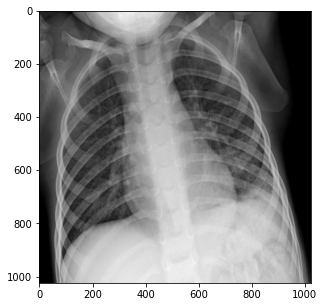

In [11]:
plt.figure(figsize = (5,5))
plt.imshow(img_orig)

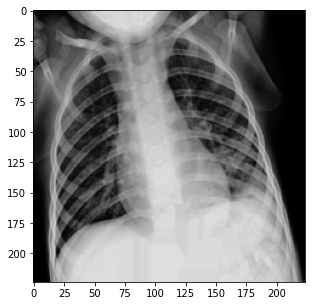

In [12]:
plt.figure(figsize = (5,5))
plt.imshow(img)

In [13]:
model = createOrRestoreModel() 








reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           batch_normal

In [14]:
def createLRPAnalyzer(model, imgNormalized):
    '''
    All possible names are: ['input', 'random', 'gradient', 'gradient.baseline', 'input_t_gradient', 
    'deconvnet', 'guided_backprop', 'integrated_gradients', 'smoothgrad', 'lrp', 'lrp.z', 'lrp.z_IB', 
    'lrp.epsilon', 'lrp.epsilon_IB', 'lrp.w_square', 'lrp.flat', 'lrp.alpha_beta', 'lrp.alpha_2_beta_1', 
    'lrp.alpha_2_beta_1_IB', 'lrp.alpha_1_beta_0', 'lrp.alpha_1_beta_0_IB', 'lrp.z_plus', 'lrp.z_plus_fast', 
    'lrp.sequential_preset_a', 'lrp.sequential_preset_b', 'lrp.sequential_preset_a_flat', 
    'lrp.sequential_preset_b_flat', 'deep_taylor', 'deep_taylor.bounded', 'deep_lift.wrapper', 
    'pattern.net', 'pattern.attribution']"
    '''

    analyzer = innvestigate.create_analyzer("lrp.sequential_preset_a_flat", model, reverse_keep_tensors=True)
    analysis = analyzer.analyze(imgNormalized)
    
    relScore = analyzer._reversed_tensors
    
    a = analysis
    a /= np.max(np.abs(a))
    
    return a, relScore

In [15]:
gradCAM = gradcamutils.grad_cam(model, imgNormalized, layer_name = 'conv2d_20') #conv2d_120
#for VGG, here there are parameters to set image width (W) and height (H)
gradCAMPlus = gradcamutils.grad_cam_plus(model, imgNormalized, layer_name = 'conv2d_20') #conv2d_120
#LRP, relScore = createLRPAnalyzer(model, imgNormalized)

gradCAM = np.array(Image.fromarray(gradCAM).resize((224,224), Image.ANTIALIAS))
gradCAMPlus = np.array(Image.fromarray(gradCAMPlus).resize((224,224), Image.ANTIALIAS))

0
0


In [16]:
pred = model.predict(imgNormalized)

class_prob = pred.tolist()
softMaxProb = class_prob[0]

softMaxProb

[0.9946874380111694, 1.9913352389266947e-07, 0.005312281660735607]

In [17]:
#for score in relScore:
    #print(score)

In [18]:
def remove_ticks_and_labels(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

In [19]:
def decisionVisualization(img, xaiMethod, vizMethod):
    # Add batch axis and preprocess   

    fig = plt.figure(constrained_layout=False,figsize=[8,4])
    gs1 = fig.add_gridspec(nrows=1, ncols=2, left=1, right=1.8)

    fig_ax1 = fig.add_subplot(gs1[0, 0])
    fig_ax2 = fig.add_subplot(gs1[0, 1])

    gs2 = fig.add_gridspec(nrows=1, ncols=1, left=1.92, right=2.6)

    fig_ax3 = fig.add_subplot(gs2[0, 0])

    fig_ax1.imshow(img, cmap ='gray')
    fig_ax1.set_title("Input radiograph")

    remove_ticks_and_labels(fig_ax1)
    
    if vizMethod == 'LRP':
        norm = LRP[0,:,:,0] 

        fig_ax2.imshow(img, cmap ='Reds_r')
        fig_ax2.imshow(norm, vmax = 1, vmin = -1,alpha=0.45, cmap="jet")
        fig_ax2.set_title(str(vizMethod))
        remove_ticks_and_labels(fig_ax2)

        #x_probs = [0.12, 0.30, 0.48, 0.10]
        x_probs = softMaxProb
        
        x_probs = np.asarray(x_probs, dtype=np.float32)
        y_pos = np.array([0, 1, 2])
        y_objects = ('Type-1','Type-2','Type-3') #Infection type
        y_labels = ['Normal', 'COVID-19', 'pneumonia']

        fig_ax3.barh(y_pos, x_probs, color='green', align='center', alpha=0.3)
        fig_ax3.set_title("Explanations")
    
        for i, v in enumerate(x_probs):
            fig_ax3.text(v - 0.07, i + 0.1 , '{0:.2f}   {1}'.format(v,y_labels[i]))
    
        fig_ax3.set_yticks(y_pos)
        fig_ax3.set_yticklabels(y_objects)
        fig_ax3.invert_yaxis()  # labels read top-to-bottom
        fig_ax3.set_xticks([0, 1, 2, 3])

        fig.savefig('explanation.png')
        
    if vizMethod == 'CAM':

        fig_ax2.imshow(img, cmap ='gray', aspect = "auto")
        fig_ax2.imshow(xaiMethod, alpha=0.45, cmap="jet")
        fig_ax2.set_title(str(vizMethod))
        remove_ticks_and_labels(fig_ax2)

        #x_probs = [0.12, 0.30, 0.48, 0.10]
        x_probs = softMaxProb
        x_probs = np.asarray(x_probs, dtype=np.float32)
        y_pos = np.array([0, 1, 2])
        y_objects = ('Type-1','Type-2','Type-3') #Infection type
        y_labels = ['Normal', 'COVID-19', 'pneumonia']

        fig_ax3.barh(y_pos, x_probs, color='blue', align='center', alpha=0.3)
        fig_ax3.set_title("Explanations")
    
        for i, v in enumerate(x_probs):
            fig_ax3.text(v - 0.07, i + 0.1 , '{0:.2f}   {1}'.format(v,y_labels[i]))
    
        fig_ax3.set_yticks(y_pos)
        fig_ax3.set_yticklabels(y_objects)
        fig_ax3.invert_yaxis()  # labels read top-to-bottom
        fig_ax3.set_xticks([0, 1, 2, 3])

        fig.savefig('explanation.png')
        
    if vizMethod == 'CAMPlus':

        fig_ax2.imshow(img, cmap ='gray', aspect = "auto")
        fig_ax2.imshow(xaiMethod, alpha=0.45, cmap="jet")
        fig_ax2.set_title(str(vizMethod))
        remove_ticks_and_labels(fig_ax2)

        #x_probs = [0.12, 0.30, 0.48, 0.10]
        x_probs = softMaxProb
        x_probs = np.asarray(x_probs, dtype=np.float32)
        y_pos = np.array([0, 1, 2])
        y_objects = ('Type-1','Type-2','Type-3') #Infection type
        y_labels = ['Normal', 'COVID-19', 'pneumonia']

        fig_ax3.barh(y_pos, x_probs, color='red', align='center', alpha=0.3)
        fig_ax3.set_title("Explanations")
    
        for i, v in enumerate(x_probs):
            fig_ax3.text(v - 0.07, i + 0.1 , '{0:.2f}   {1}'.format(v,y_labels[i]))
    
        fig_ax3.set_yticks(y_pos)
        fig_ax3.set_yticklabels(y_objects)
        fig_ax3.invert_yaxis()  # labels read top-to-bottom
        fig_ax3.set_xticks([0, 1, 2, 3])

        fig.savefig('explanation.png')

In [20]:
#decisionVisualization(img, xaiMethod=LRP, vizMethod='LRP')

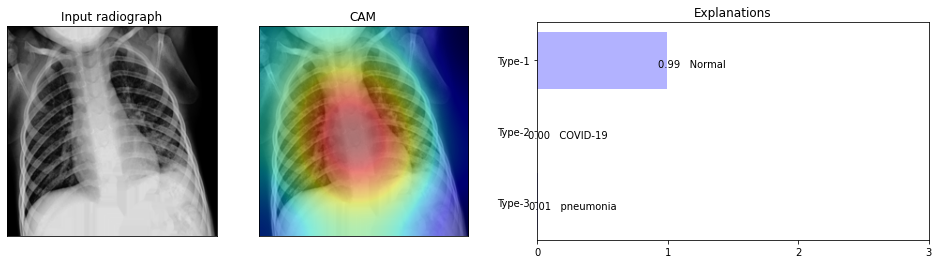

In [21]:
decisionVisualization(img, xaiMethod=gradCAM, vizMethod='CAM')

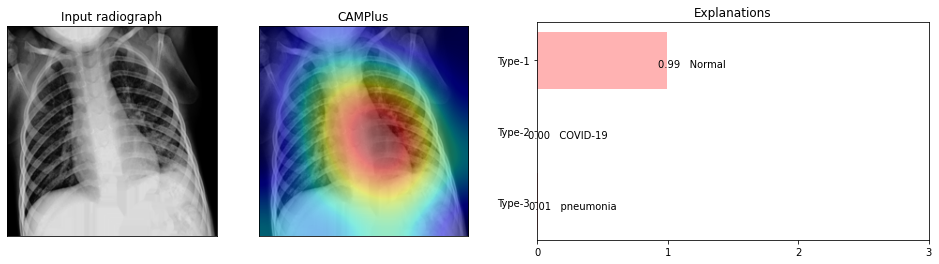

In [22]:
decisionVisualization(img, xaiMethod=gradCAMPlus, vizMethod='CAMPlus')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       100
           1       0.33      1.00      0.50       100
           2       0.00      0.00      0.00       100

    accuracy                           0.33       300
   macro avg       0.11      0.33      0.17       300
weighted avg       0.11      0.33      0.17       300



C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Aleksander Podsiad\.conda\envs\WB_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

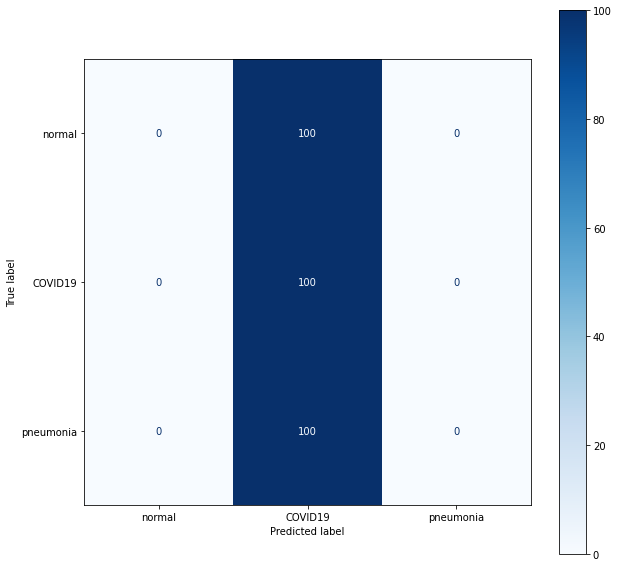

In [23]:
x_test = np.load('preprocessed/x_test_prep.npy')
y_test = np.load('preprocessed/y_test_prep.npy', allow_pickle = True)

from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
y_pred = y_pred.reshape(len(y_test), 3)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['normal', 'COVID19', 'pneumonia']))
disp.plot(cmap='Blues') 
disp.ax_.get_images()[0].set_clim(0, 100)